In [66]:
## perform imports and set-up
import numpy as np
import pandas as pd
import statsmodels.api as sm

from scipy import stats
from matplotlib import pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
plt.style.use('ggplot') # emulate pretty r-style plots

In [67]:
boston = pd.read_csv("../DataForLab/Boston.csv")

Simple Scatterplot with `plt`

beta= [ 34.554 , -0.95 ]
R=-0.738, p_value=0.000, stderr=0.039


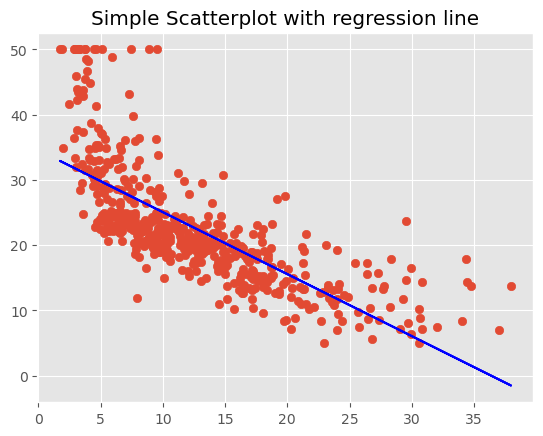

In [68]:
scatter1Fig, scatter1 = plt.subplots()
scatter1.scatter(x=boston["lstat"],y=boston["medv"])
scatter1.set_title("Simple Scatterplot with regression line")

beta1, beta0, r_value, p_value, stderr = stats.linregress(boston["lstat"],y=boston["medv"])

# add the estimation to the data plot
scatter1.plot(boston["lstat"], beta0 + beta1*boston["lstat"],color='b', label="OLS")


# print the regression estimates returned from scipy
print('beta= [',round(beta0,3),',', round(beta1,3),']')
print('R={0:.3f}, p_value={1:.3f}, stderr={2:.3f}'.format(r_value, p_value, stderr))


Scatterplot with statsmodel

In [69]:
#define the predictor
X = boston["lstat"]

# We add a constant of 1 for the intercept term
X = sm.add_constant(X)

# we need to add constant because Y = mX + C
# see documentation https://www.statsmodels.org/devel/generated/statsmodels.regression.linear_model.OLS.html

# set the dependent variable
Y = boston["medv"]

# create the model instance and fit
linear_model = sm.OLS(Y,X)
linear_results = linear_model.fit()
# data about the model is stored in summary



In [70]:
# statsmodels includes functions for getting the prediction and confidence intervals.

# Get prediction interval for a given x
prstd, iv_l, iv_u = wls_prediction_std(linear_results)

# statsmodels also includes the confidence intervals for the fitted values (i.e. the mean fits)
# but they are buried in the results of summary table function.
from statsmodels.stats.outliers_influence import summary_table

# call the summary table at a (1-alpha)100% confidence interval level
simpleTable, data, column_names = summary_table(linear_results, alpha=0.05)



# Get confidence intervals for a given x
predicted_mean_ci_low, predicted_mean_ci_high = data[:,4:6].T
# the array slice means , take all rows, choose only index 4 to index 5 columns
# .T transposes the array / flip it against its diagonal https://numpy.org/doc/stable/reference/generated/numpy.transpose.html#numpy.transpose
# we basically expressed the 2 terms in corresponding to i-th row rather than them currently in array of arrays of pairs

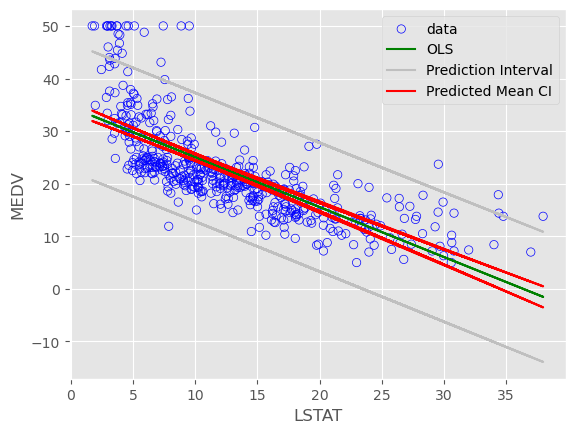

In [71]:
# Create a plot to plot the data, OLS estimate, prediction and confidence intervals
fig, ax = plt.subplots()

# get numpy array values from dataframe
x = boston["lstat"]
y = boston["medv"]

# Plot the data
ax.scatter(x, y, facecolors='none', edgecolors='b', label="data")
# plot the models fitted values
ax.plot(x, linear_results.fittedvalues, 'g', label="OLS")

# plot the high and low prediction intervals
ax.plot(x, iv_u, color='0.75',label="Prediction Interval")
ax.plot(x, iv_l, color='0.75')

# plot the high and low mean confidence intervals
ax.plot(x,predicted_mean_ci_low, 'r', label="Predicted Mean CI")
ax.plot(x,predicted_mean_ci_high,'r')

ax.legend(loc='best');

plt.xlabel('LSTAT');
plt.ylabel('MEDV');



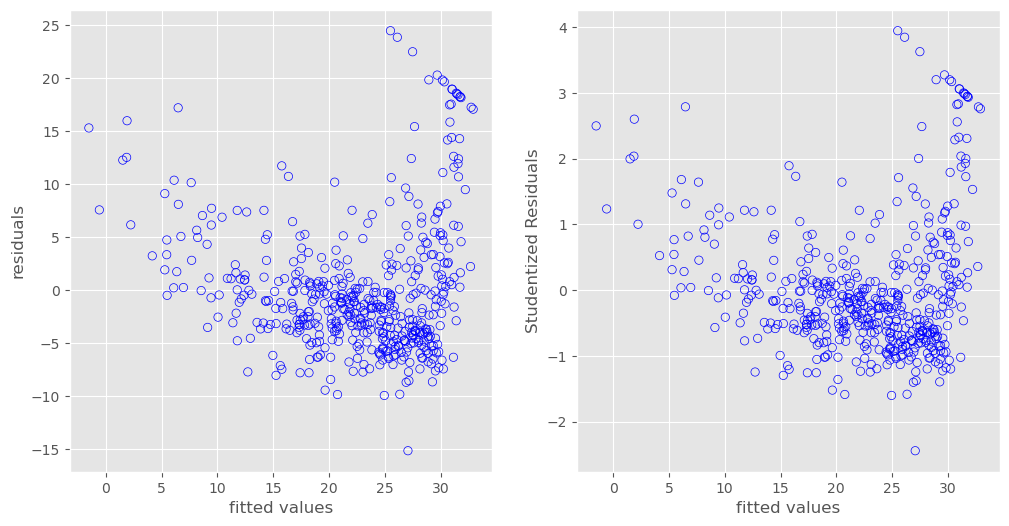

In [72]:
# Create plots of residuals
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

# RESIDUALS
# The results contain the residuals
fitted_values = data[:,2] #predicted Y
residuals = data[:,8] #error

#alter
#fitted_values = linear_results.fittedvalues.values
#residuals = linear_results.resid.values

# Plot the residual for each fitted value
ax1.scatter(fitted_values, residuals, facecolors='none', edgecolors='b');
ax1.set_xlabel('fitted values');
ax1.set_ylabel('residuals');
# The residual plot indicates significant nonlinearity (a u-shape pattern is clear)

# STUDENTIZED RESIDUALS
# To asses data outliers we will look at the studentized residuals. This is in the data array 
# returned from summary table (10th column)
studentized_residuals = data[:,10]

# Plot the studentized residuals
ax2.scatter(fitted_values,studentized_residuals, facecolors='none', edgecolors='b');
ax2.set_ylabel('Studentized Residuals');
ax2.set_xlabel('fitted values');

# |studentized residual| > 3 are generally considered outliers

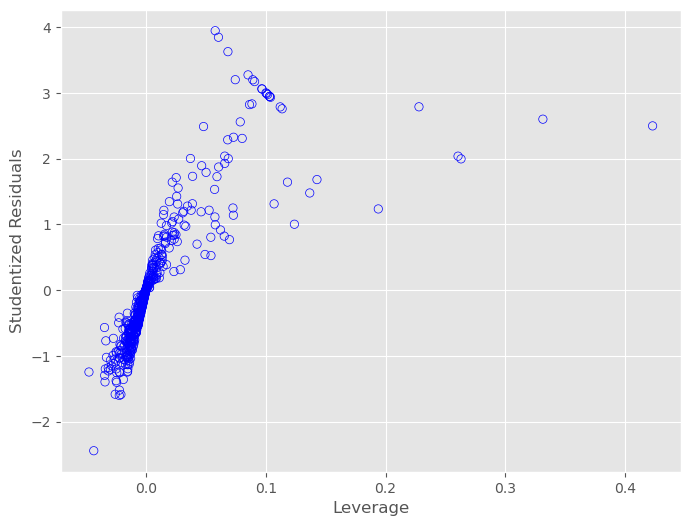

In [73]:
# We can also examine the leverages to identify points that may alter the regression line
from statsmodels.stats.outliers_influence import OLSInfluence
leverage = OLSInfluence(linear_results).influence

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(leverage, studentized_residuals,facecolors='none', edgecolors='b');
ax.set_xlabel('Leverage');
ax.set_ylabel('Studentized Residuals');

Model parameters:
 const    33.222761
lstat    -1.032069
age       0.034544
dtype: float64


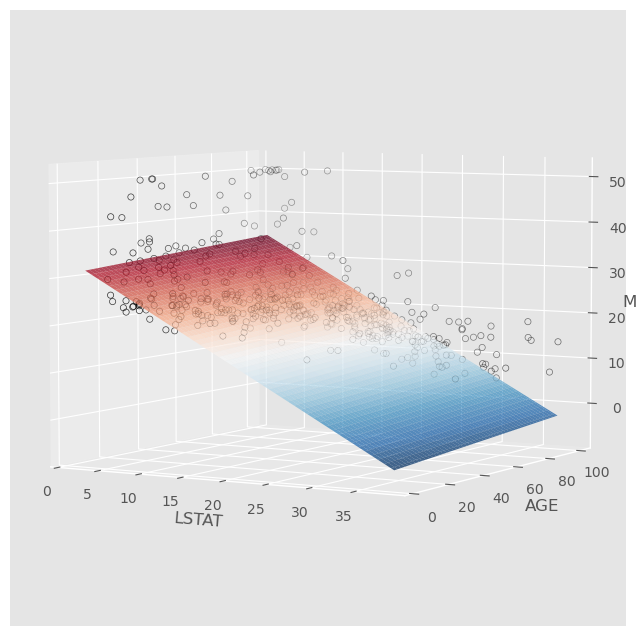

In [74]:
# create our design matrix using LSTAT and AGE predictors
#i.e. this is a multivariable regression
#X is now a 3 column dataset
X = sm.add_constant(boston[['lstat','age']])

# set the dependent variable
Y = boston["medv"]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d',azim=-60, elev=5)

# create the model instance and estimate
model = sm.OLS(Y,X)
estimate = model.fit()
# data about the model is stored in summary
print('Model parameters:\n', estimate.params[:])

# Plot the data
ax.scatter(X.loc[:,'lstat'], X.loc[:,'age'], Y.values, facecolors=(0,0,0,0),\
           edgecolor='k', depthshade=True);
ax.set_xlabel('LSTAT');
ax.set_ylabel('AGE')
ax.set_zlabel('MEDV')

# Plot the OLS estimate
# create a grid of points
xx1, xx2 = np.meshgrid(np.linspace(X.lstat.min(), X.lstat.max(), 100), 
                       np.linspace(X.age.min(), X.age.max(), 100))

# plot the plane by evaluating the parameters over the grid
Z = estimate.params[0] + estimate.params[1] * xx1 + estimate.params[2] * xx2
# plot plane
surf = ax.plot_surface(xx1, xx2, Z, cmap=plt.cm.RdBu_r, alpha=0.75, linewidth=0)

In [75]:
# create our design matrix using all the predictors (last column is MEDV)
# the use of -1 means the very last column (i.e. 1st column from the right) is ignored
X = sm.add_constant(boston.iloc[:,0:-1])

# create the model instance and estimate
model = sm.OLS(Y,X)
est = model.fit()
# data about the model is stored in summary
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Fri, 26 May 2023   Prob (F-statistic):          6.72e-135
Time:                        12:14:36   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.4595      5.103      7.144      0.0

In [76]:
# Compute all the variance inflation factors
from statsmodels.stats.outliers_influence import variance_inflation_factor

VIFs = [(predictor, variance_inflation_factor(X.values,_)) \
        for _,predictor in enumerate(list(X))] # list(X) returns column names of df

print('Variance Inflation Factors')
for tup in VIFs:
    print('{:10}'.format(tup[0]), '{:.3f}'.format(tup[1]))

Variance Inflation Factors
const      585.265
crim       1.792
zn         2.299
indus      3.992
chas       1.074
nox        4.394
rm         1.934
age        3.101
dis        3.956
rad        7.484
tax        9.009
ptratio    1.799
black      1.349
lstat      2.941


In [77]:
boston["lstate:age"] = boston["lstat"] * boston["age"]
X = sm.add_constant(boston[["lstat",'age',"lstate:age"]])
Y = boston["medv"]
model = sm.OLS(Y,X)
est = model.fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     209.3
Date:                Fri, 26 May 2023   Prob (F-statistic):           4.86e-88
Time:                        12:14:37   Log-Likelihood:                -1635.0
No. Observations:                 506   AIC:                             3278.
Df Residuals:                     502   BIC:                             3295.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.0885      1.470     24.553      0.0

In [78]:
boston["lstat^2"] = boston["lstat"] ** 2
X = sm.add_constant(boston[["lstat","lstat^2"]])
Y = boston["medv"]
model = sm.OLS(Y,X)
quadResult = model.fit()
print(quadResult.summary())

#The near zero p-value for the quadratic term suggest an improved model.

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     448.5
Date:                Fri, 26 May 2023   Prob (F-statistic):          1.56e-112
Time:                        12:14:37   Log-Likelihood:                -1581.3
No. Observations:                 506   AIC:                             3169.
Df Residuals:                     503   BIC:                             3181.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         42.8620      0.872     49.149      0.0

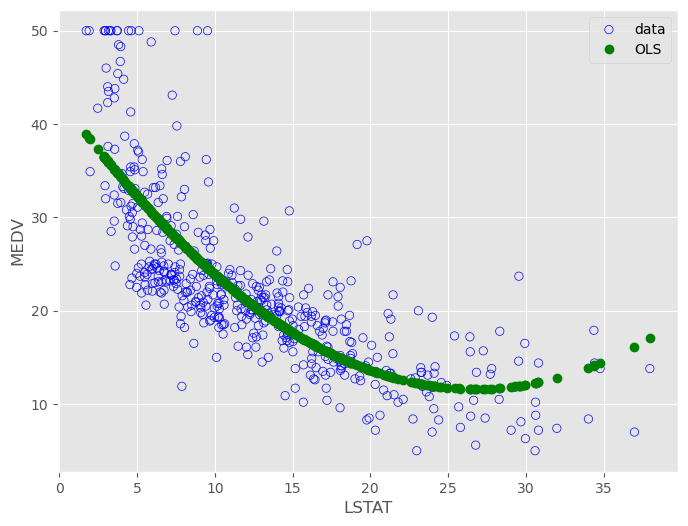

In [79]:
fig, ax = plt.subplots(figsize=(8,6))

# get numpy array values from dataframe
x = boston["lstat"]
y = boston["medv"]

# Plot the data
ax.scatter(x, y, facecolors='none', edgecolors='b', label="data");
# plot the models fitted values
ax.plot(x, quadResult.fittedvalues, 'g', marker='o',linestyle='none', label="OLS");

ax.legend(loc='best');

plt.xlabel('LSTAT');
plt.ylabel('MEDV');

In [80]:
# import anova function
from statsmodels.stats.api import anova_lm

# perform the hypothesis test (see https://en.wikipedia.org/wiki/F-test regression section)
anova_table = anova_lm(linear_results, quadResult)
print(anova_table)

   df_resid           ssr  df_diff     ss_diff           F        Pr(>F)
0     504.0  19472.381418      0.0         NaN         NaN           NaN
1     503.0  15347.243158      1.0  4125.13826  135.199822  7.630116e-28


#### The F-statistic is 135 with a p-value of ~0 indicating there is a large difference in the unexplained variances of the two models. This is not too suprising given the plot above. Now consider the residuals.

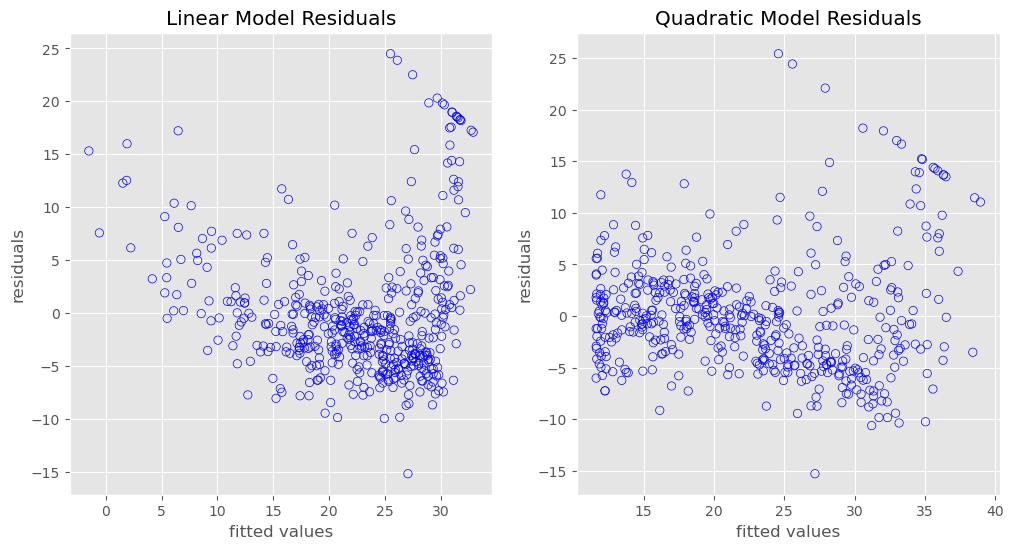

In [81]:
# Create plots of residuals
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

# RESIDUALS OF LINEAR MODEL
# The results contain the residuals
linear_fit_values = linear_results.fittedvalues.values
residuals = linear_results.resid.values

# Plot the residual for each fitted value for the linear model
ax1.scatter(linear_fit_values, residuals, facecolors='none', edgecolors='b');
ax1.set_xlabel('fitted values');
ax1.set_ylabel('residuals');
ax1.set_title('Linear Model Residuals')

# RESIDUALS OF QUADRATIC MODEL
# The results contain the residuals
quadratic_fit_values = quadResult.fittedvalues.values
quadratic_residuals = quadResult.resid.values
ax2.scatter(quadratic_fit_values, quadratic_residuals, facecolors='none', edgecolors='b');
ax2.set_xlabel('fitted values');
ax2.set_ylabel('residuals');
ax2.set_title('Quadratic Model Residuals');

In [82]:
for i in range(2,6):
    boston["lstat^"+str(i)] = boston["lstat"] ** i
X = sm.add_constant(boston[["lstat","lstat^2","lstat^3","lstat^4","lstat^5"]])
model = sm.OLS(boston["medv"],X)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     214.2
Date:                Fri, 26 May 2023   Prob (F-statistic):          8.73e-122
Time:                        12:14:37   Log-Likelihood:                -1550.6
No. Observations:                 506   AIC:                             3113.
Df Residuals:                     500   BIC:                             3139.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         67.6997      3.604     18.783      0.0

In [100]:
carseats = pd.read_csv("../DataForLab/Carseats.csv")
import statsmodels.formula.api as smf

# Construct the formula with two interaction terms
# The default treatment for categoricals in patsy is the reference=0. In this case the dummy variable for bad is 0.
# more treatments can be found in the patsy documentation. ....from patsy.contrasts import Treatment
formula ='Sales ~' + '+'.join(list(carseats.iloc[:,2:].columns.tolist()) + ['Income:Advertising'] + ['Price:Age'])
# 2: to ignore unique index and sales
print(formula)

print()

model = smf.ols(formula, data=carseats)
carseat_results = model.fit()
print(carseat_results.summary())

Sales ~CompPrice+Income+Advertising+Population+Price+ShelveLoc+Age+Education+Urban+US+Income:Advertising+Price:Age

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     210.0
Date:                Fri, 26 May 2023   Prob (F-statistic):          6.14e-166
Time:                        12:39:47   Log-Likelihood:                -564.67
No. Observations:                 400   AIC:                             1157.
Df Residuals:                     386   BIC:                             1213.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
------